In [128]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge geocoder --yes
#import geocoder
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests
from bs4 import BeautifulSoup
import re
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


# Import the newyork Data

In [129]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head(3)
boroughs=neighborhoods[~neighborhoods['Borough'].duplicated()].reset_index(drop=True)
boroughs.drop(['Neighborhood'],axis=1,inplace=True)


## Function to get all the hotels in the area using Foursquare

In [130]:
def getNearbyHotels(names, latitudes, longitudes):
    
    hotel_lists=[]
    search_query = 'Restaurant'
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat,
            lng,
            VERSION,
            search_query,RADIUS,LIMIT)  

        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        # return only relevant information for each nearby hotels
        hotel_lists.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories'][0]['name']) for v in results])

    Hotels = pd.DataFrame([item for hotel_list in hotel_lists for item in hotel_list])
    Hotels.columns = ['Borough', 
                      'Borough Latitude', 
                      'Borough Longitude', 
                      'Hotel Name', 
                      'Hotel Latitude', 
                      'Hotel Longitude',
                       'Hotel Category']
    return(Hotels)                                                                                                                                    

In [131]:
Hotels=getNearbyHotels(names=boroughs['Borough'],
                           latitudes=boroughs['Latitude'],
                           longitudes=boroughs['Longitude']
                          )
Hotels.head(4)

Borough  Borough Latitude  Borough Longitude  \
0   Bronx         40.894705         -73.847201   
1   Bronx         40.894705         -73.847201   
2   Bronx         40.894705         -73.847201   
3   Bronx         40.894705         -73.847201   

                               Hotel Name  Hotel Latitude  Hotel Longitude  \
0  Big Daddy's Caribbean Taste Restaurant       40.899767       -73.857135   
1            Junior's Restaurant & Bakery       40.758539       -73.986477   
2                      Waverly Restaurant       40.733012       -74.000124   
3           Red Flower Chinese Restaurant       40.904359       -73.849795   

         Hotel Category  
0  Caribbean Restaurant  
1   American Restaurant  
2                 Diner  
3    Chinese Restaurant

In [132]:
Hotels.shape

(250, 7)

In [133]:
# one hot encoding
Hotel_onehot = pd.get_dummies(Hotels[['Hotel Category']], prefix="", prefix_sep="")

# add Hotel Name column back to dataframe
Hotel_onehot['Hotel Name'] = Hotels['Hotel Name'] 

# move Hotel name column to the first column
fixed_columns = [Hotel_onehot.columns[-1]] + list(Hotel_onehot.columns[:-1])
Hotel_onehot = Hotel_onehot[fixed_columns]

Hotel_onehot.head(6)
Hotel_merged=pd.merge(Hotel_onehot,Hotels,on=['Hotel Name'])
Hotel_merged['Bor']=Hotel_merged['Borough']
fixed_columns = [Hotel_merged.columns[-1]] + list(Hotel_merged.columns[:-1])
Hotel_merged=Hotel_merged[fixed_columns]
Hotel_merged.drop(Hotel_merged.columns[-6:],axis=1,inplace=True)
Hotel_merged.rename(columns={'Bor':'Borough'},inplace=True)
Hotel_merged.head(4)
Hotel_cluster_df=Hotel_merged

In [134]:
Hotel_grouped = Hotel_merged.groupby(['Borough','Hotel Name']).mean().reset_index()
Hotel_grouped.drop(Hotel_grouped.columns[1],axis=1,inplace=True)
Hotel_grouped=Hotel_grouped.groupby('Borough').sum().reset_index().head(4)
Hotel_grouped.head(3)


Borough  American Restaurant  Bakery  Bar  Brazilian Restaurant  Café  \
0      Bronx                  6.0     1.0  0.0                   1.0   0.0   
1   Brooklyn                  3.0     1.0  1.0                   0.0   0.0   
2  Manhattan                  3.0     1.0  1.0                   0.0   1.0   

   Caribbean Restaurant  Chinese Restaurant  Cocktail Bar  Cuban Restaurant  \
0                   4.0                 6.0           1.0               0.0   
1                   0.0                 8.0           1.0               0.0   
2                   2.0                 6.0           1.0               0.0   

   Dim Sum Restaurant  Diner  Dumpling Restaurant  Filipino Restaurant  Food  \
0                 3.0   10.0                  0.0                  0.0   0.0   
1                 5.0    7.0                  0.0                  0.0   0.0   
2                 3.0    9.0                  1.0                  0.0   0.0   

   French Restaurant  German Restaurant  Greek Restaurant  Hookah Bar  \
0                1.0                1.0               0.0         0.0   
1                0.0                1.0               0.0         1.0   
2                0.0                1.0               0.0         0.0   

   Hotel Bar  Indian Restaurant  Irish Pub  Italian Restaurant  \
0        1.0                0.0   0.714286                 3.0   
1        1.0                0.0   0.714286                 6.0   
2        1.0                1.0   0.714286                 5.0   

   Kitchen Supply Store  Latin American Restaurant  Malay Restaurant  \
0                   1.0                        2.0               0.0   
1                   0.0                        0.0               1.0   
2                   0.0                        2.0               0.0   

   Mexican Restaurant  Middle Eastern Restaurant  Miscellaneous Shop  \
0                 0.0                        0.0                 0.0   
1                 2.0                        1.0                 1.0   
2                 2.0                        0.0                 0.0   

   Pizza Place       Pub  Restaurant  Sandwich Place  Seafood Restaurant  \
0          0.0  1.285714         2.0             0.0                 1.0   
1          1.0  2.285714         2.0             1.0                 0.0   
2          0.0  1.285714         4.0             0.0                 1.0   

   South American Restaurant  Southern / Soul Food Restaurant  \
0                        0.0                              1.0   
1                        0.0                              0.0   
2                        0.0                              0.0   

   Spanish Restaurant  Sushi Restaurant  Thai Restaurant  Turkish Restaurant  \
0                 1.0               0.0              0.0                 0.0   
1                 0.0               0.0              1.0                 1.0   
2                 3.0               0.0              0.0                 0.0   

   Vietnamese Restaurant  Wings Joint  
0                    0.0          0.0  
1                    1.0          0.0  
2                    0.0          0.0

In [135]:
# set number of clusters
kclusters = 10

Hotel_clustering = Hotel_cluster_df.drop(['Borough','Hotel Name'], 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Hotel_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [136]:
kmeans.labels_

array([0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 0, 5,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [137]:
hotel_merged_cluster = Hotel_cluster_df

# add clustering labels
hotel_merged_cluster['Cluster Labels'] = kmeans.labels_

# merge Hotel with merged dataframe to add latitude/longitude for each Hotel
hotel_merged_cluster = hotel_merged_cluster.join(Hotels.set_index('Hotel Name'), on='Hotel Name',how='left', lsuffix='_left', rsuffix='_right')
hotel_merged_cluster.head(1) # check the last columns!


Borough_left                              Hotel Name  American Restaurant  \
0        Bronx  Big Daddy's Caribbean Taste Restaurant                    0   

   Bakery  Bar  Brazilian Restaurant  Café  Caribbean Restaurant  \
0       0    0                     0     0                     1   

   Chinese Restaurant  Cocktail Bar  Cuban Restaurant  Dim Sum Restaurant  \
0                   0             0                 0                   0   

   Diner  Dumpling Restaurant  Filipino Restaurant  Food  French Restaurant  \
0      0                    0                    0     0                  0   

   German Restaurant  Greek Restaurant  Hookah Bar  Hotel Bar  \
0                  0                 0           0          0   

   Indian Restaurant  Irish Pub  Italian Restaurant  Kitchen Supply Store  \
0                  0          0                   0                     0   

   Latin American Restaurant  Malay Restaurant  Mexican Restaurant  \
0                          0                 0                   0   

   Middle Eastern Restaurant  Miscellaneous Shop  Pizza Place  Pub  \
0                          0                   0            0    0   

   Restaurant  Sandwich Place  Seafood Restaurant  South American Restaurant  \
0           0               0                   0                          0   

   Southern / Soul Food Restaurant  Spanish Restaurant  Sushi Restaurant  \
0                                0                   0                 0   

   Thai Restaurant  Turkish Restaurant  Vietnamese Restaurant  Wings Joint  \
0                0                   0                      0            0   

   Cluster Labels Borough_right  Borough Latitude  Borough Longitude  \
0               0         Bronx         40.894705         -73.847201   

   Hotel Latitude  Hotel Longitude        Hotel Category  
0       40.899767       -73.857135  Caribbean Restaurant

## Create map of New York with 10 cluster of the hotels

In [148]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotel_merged_cluster['Hotel Latitude'], hotel_merged_cluster['Hotel Longitude'], hotel_merged_cluster['Hotel Name'], hotel_merged_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


## Word Cloud to view which restaurant type is more prominent accross the boroughs

In [139]:
HotelTypes=[]
weight=30
for cnt, row in Hotels.iterrows():
    HotelTypes.append(' {} '.format(row['Hotel Category']) *weight)
strHotelTypes=''.join(HotelTypes)


In [140]:
# instantiate a word cloud object
stopwords=set(STOPWORDS)
stopwords.add('Restaurant')
Hotel_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
Hotel_wc.generate(strHotelTypes)

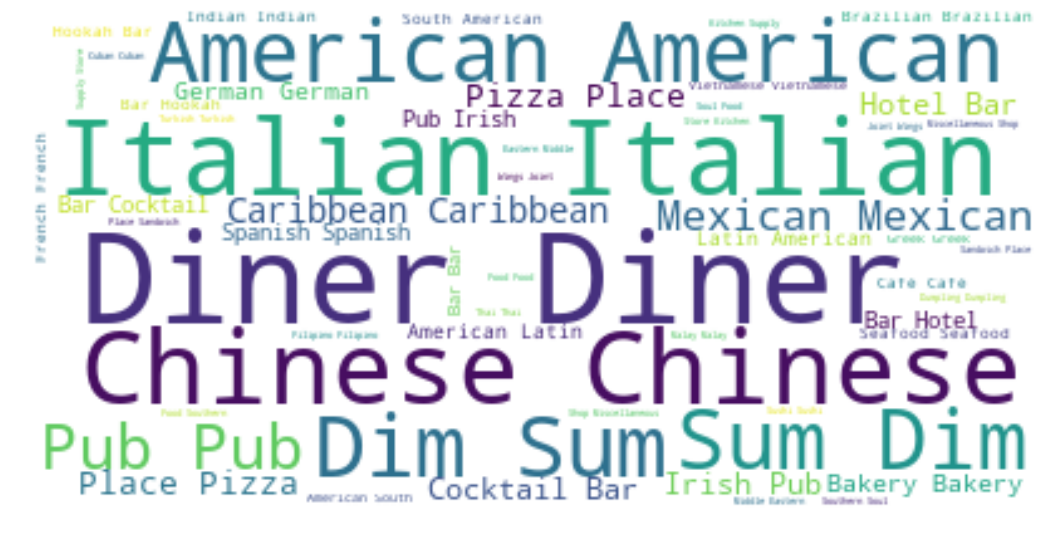

In [141]:
# display the word cloud
# display the cloud
fig = plt.figure()
fig.set_figwidth(18) # set width
fig.set_figheight(20) # set height
plt.imshow(Hotel_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Create bar chart to view which are the top 15 and bottom 15 restaurants in each borough

## Function to get the top 15 restaurants in the boroughs

In [142]:
def gettop15hotels(cnt):
    Hotelsort=Hotel_grouped.iloc[cnt][1:].to_frame().reset_index()
    fixed_column=['Hotel','Total']
    Hotelsort.columns=fixed_column
    Hotelsort=Hotelsort.sort_values(ascending=False,by='Total').head(15)
    Hotelsort.reset_index(drop=True,inplace=True)
    return Hotelsort

In [143]:
Hotel_plottop15=pd.DataFrame(columns=['Hotel','Total','Borough'])
for cnt,row in Hotel_grouped.iterrows():
    temp=gettop15hotels(cnt)
    temp['Borough']=Hotel_grouped['Borough'][cnt]
    fixed_column=['Hotel','Total','Borough']
    temp.columns=fixed_column
    temp.astype({'Total':'int'})
    Hotel_plottop15=Hotel_plottop15.append(temp,ignore_index=True)
Hotel_plottop15.head(3)

Hotel Total Borough
0                Diner    10   Bronx
1  American Restaurant     6   Bronx
2   Chinese Restaurant     6   Bronx

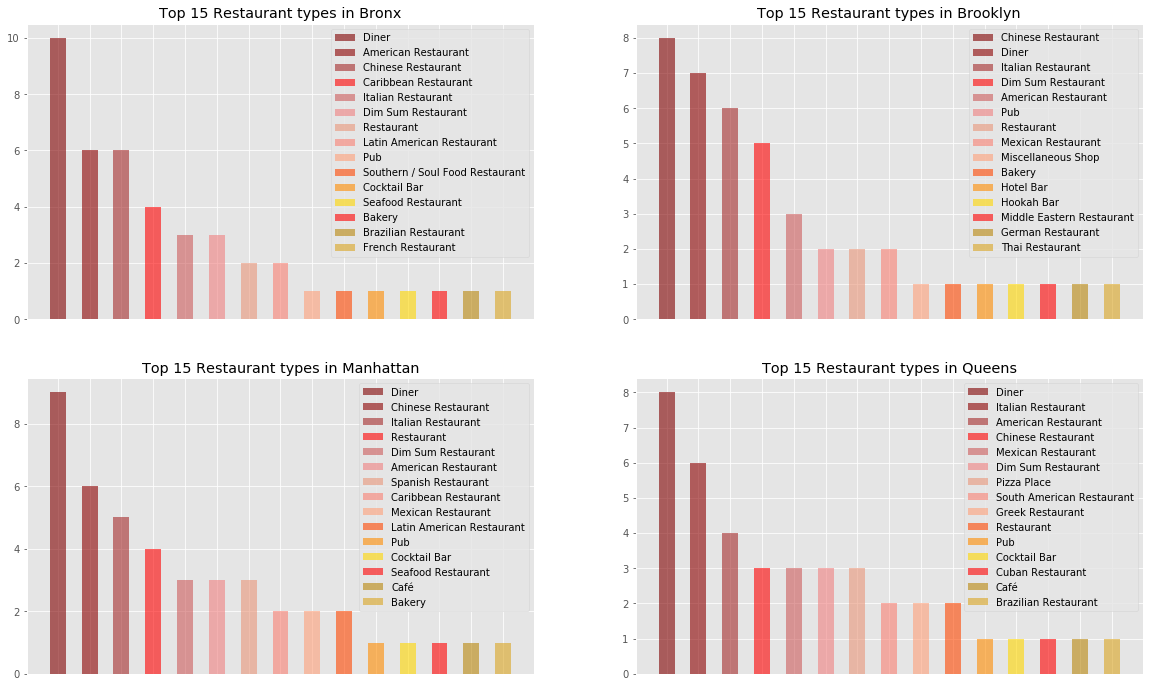

In [144]:
number_of_subplots=4
cnt=0
for i,v in enumerate(range(Hotel_grouped.shape[0])):
    v = v+1
    ax1 = plt.subplot(number_of_subplots,2,v)
    cnt=i+(14*i)
    plthoteltype = {1:(Hotel_plottop15['Hotel'][0+cnt],'maroon'), 
                  2:(Hotel_plottop15['Hotel'][1+cnt],'darkred'), 
                  3:(Hotel_plottop15['Hotel'][2+cnt],'brown'), 
                  4:(Hotel_plottop15['Hotel'][3+cnt],'red'), 
                  5:(Hotel_plottop15['Hotel'][4+cnt],'indianred'), 
                  6:(Hotel_plottop15['Hotel'][5+cnt], 'lightcoral'), 
                  7:(Hotel_plottop15['Hotel'][6+cnt], 'darksalmon'),
                  8:(Hotel_plottop15['Hotel'][7+cnt],'salmon'), 
                  9:(Hotel_plottop15['Hotel'][8+cnt],'lightsalmon'), 
                  10:(Hotel_plottop15['Hotel'][9+cnt],'orangered'), 
                  11:(Hotel_plottop15['Hotel'][10+cnt],'darkorange'), 
                  12:(Hotel_plottop15['Hotel'][11+cnt],'gold'), 
                  13:(Hotel_plottop15['Hotel'][12+cnt], 'red'), 
                  14:(Hotel_plottop15['Hotel'][13+cnt], 'darkgoldenrod'),
                 15:(Hotel_plottop15['Hotel'][14+cnt], 'goldenrod')}
    ax1.set_title('Top 15 Restaurant types in '+Hotel_plottop15['Borough'][cnt])
    xval = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    yval=list(map(int,Hotel_plottop15['Total'][cnt:15+cnt]))
    for j in range(len(xval)):
        ax1.bar(xval[j], yval[j], width=0.5, bottom=0.0, align='center', color=plthoteltype[xval[j]][1], alpha=0.6, label=plthoteltype[xval[j]][0])
    ax1.set_xticks(xval)
    ax1.legend()
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
plt.gcf().set_size_inches(20, 25)
plt.show()

## Function to get the 15 restaurants which are lesser in number in the boroughs

In [145]:
def getbot15hotels(cnt):
    Hotelsort=Hotel_grouped.iloc[cnt][1:].to_frame().reset_index()
    fixed_column=['Hotel','Total']
    Hotelsort.columns=fixed_column
    Hotelsort=Hotelsort[Hotelsort['Total']>0]
    Hotelsort=Hotelsort.sort_values(ascending=True,by='Total').head(15)
    Hotelsort.reset_index(drop=True,inplace=True)
    return Hotelsort

In [146]:
Hotel_plotbot15=pd.DataFrame(columns=['Hotel','Total','Borough'])
for cnt,row in Hotel_grouped.iterrows():
    temp=getbot15hotels(cnt)
    temp['Borough']=Hotel_grouped['Borough'][cnt]
    fixed_column=['Hotel','Total','Borough']
    temp.columns=fixed_column
    temp.astype({'Total':'int'})
    Hotel_plotbot15=Hotel_plotbot15.append(temp,ignore_index=True)
Hotel_plotbot15.head(2)

Hotel     Total Borough
0          Irish Pub  0.714286   Bronx
1  German Restaurant         1   Bronx

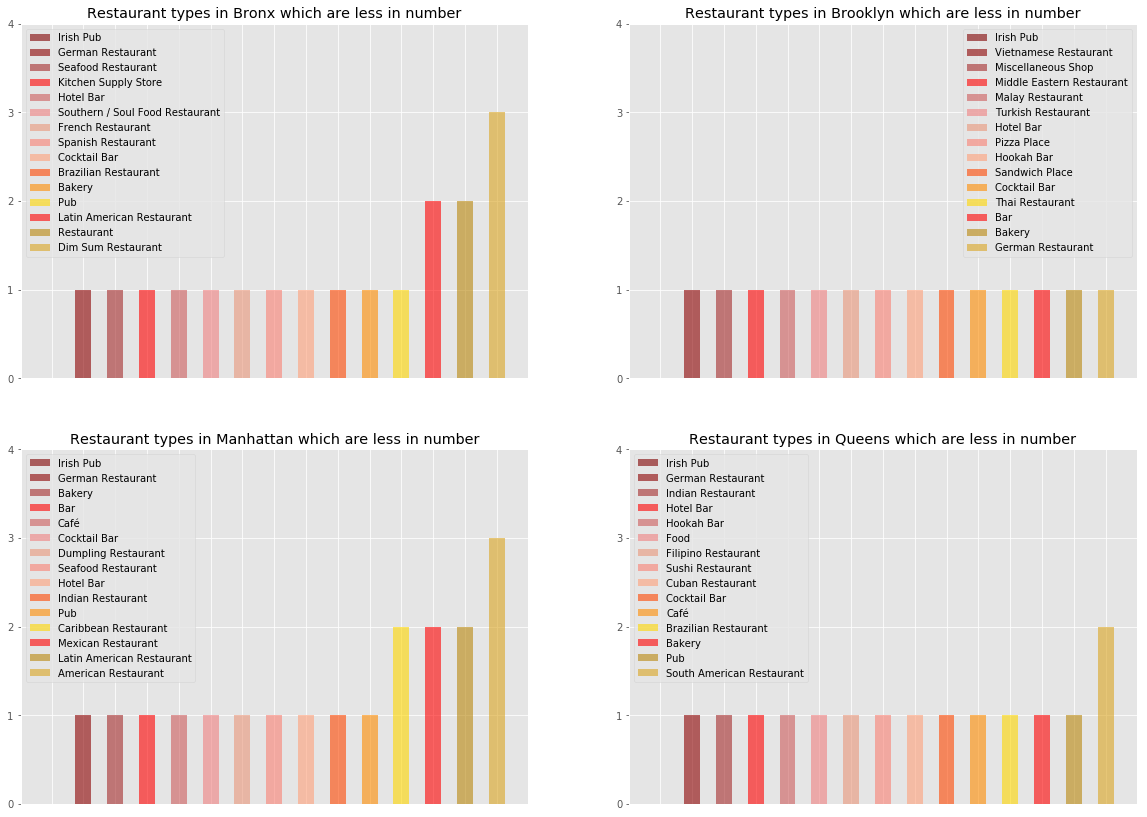

In [147]:
number_of_subplots=4
cnt=0
for i,v in enumerate(range(Hotel_grouped.shape[0])):
    v = v+1
    ax1 = plt.subplot(number_of_subplots,2,v)
    cnt=i+(14*i)
    plthoteltype = {1:(Hotel_plotbot15['Hotel'][0+cnt],'maroon'), 
                  2:(Hotel_plotbot15['Hotel'][1+cnt],'darkred'), 
                  3:(Hotel_plotbot15['Hotel'][2+cnt],'brown'), 
                  4:(Hotel_plotbot15['Hotel'][3+cnt],'red'), 
                  5:(Hotel_plotbot15['Hotel'][4+cnt],'indianred'), 
                  6:(Hotel_plotbot15['Hotel'][5+cnt], 'lightcoral'), 
                  7:(Hotel_plotbot15['Hotel'][6+cnt], 'darksalmon'),
                  8:(Hotel_plotbot15['Hotel'][7+cnt],'salmon'), 
                  9:(Hotel_plotbot15['Hotel'][8+cnt],'lightsalmon'), 
                  10:(Hotel_plotbot15['Hotel'][9+cnt],'orangered'), 
                  11:(Hotel_plotbot15['Hotel'][10+cnt],'darkorange'), 
                  12:(Hotel_plotbot15['Hotel'][11+cnt],'gold'), 
                  13:(Hotel_plotbot15['Hotel'][12+cnt], 'red'), 
                  14:(Hotel_plotbot15['Hotel'][13+cnt], 'darkgoldenrod'),
                 15:(Hotel_plotbot15['Hotel'][14+cnt], 'goldenrod')}
    ax1.set_title('Restaurant types in '+Hotel_plotbot15['Borough'][cnt]+' which are less in number')
    xval = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    yval=list(map(int,Hotel_plotbot15['Total'][cnt:15+cnt]))
    for j in range(len(xval)):
        ax1.bar(xval[j], yval[j], width=0.5, bottom=0.0, align='center', color=plthoteltype[xval[j]][1], alpha=0.6, label=plthoteltype[xval[j]][0])
    ax1.set_xticks(xval)
    ax1.set_yticks(list(range(5)))
    ax1.legend()
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
plt.gcf().set_size_inches(20, 30)
plt.show()